# Model Optimization

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/ardhiraka/PFDS_sources/master/Iklan_sosmed.csv')
df.head()

,User ID,Kelamin,Usia,EstimasiGaji,Beli
0,15624510,Laki,19,19000,0
1,15810944,Laki,35,20000,0
2,15668575,Perempuan,26,43000,0
3,15603246,Perempuan,27,57000,0
4,15804002,Laki,19,76000,0


In [ ]:
df.drop('User ID', axis=1, inplace=True)
df.Kelamin = df.Kelamin.map({'Laki':1, 'Perempuan':0})

In [ ]:
df.head()

,Kelamin,Usia,EstimasiGaji,Beli
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


In [ ]:
X = df.drop('Beli', axis=1)
y = df['Beli']

In [ ]:
X.head()

,Kelamin,Usia,EstimasiGaji
0,1,19,19000
1,1,35,20000
2,0,26,43000
3,0,27,57000
4,1,19,76000


In [ ]:
X.shape

(400, 3)

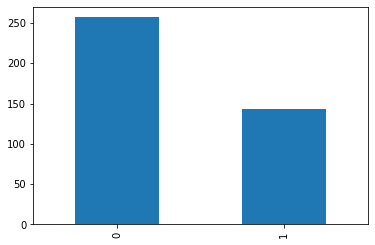

In [ ]:
y.value_counts().plot(kind='bar')

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
minmax.fit(X_train)
X_train_norm = minmax.transform(X_train)
X_test_norm = minmax.transform(X_test)

In [ ]:
# baseline model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_pred,y_test))
print(accuracy_score(y_pred, y_test))

[[48  5]
 [ 3 24]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        53
           1       0.83      0.89      0.86        27

    accuracy                           0.90        80
   macro avg       0.88      0.90      0.89        80
weighted avg       0.90      0.90      0.90        80

0.9


In [ ]:
?RandomForestClassifier

In [ ]:
%%time
# Manual Search

model_1 = RandomForestClassifier(n_estimators=300,
                                 criterion='entropy',
                                 max_features='sqrt',
                                 min_samples_leaf=10)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_pred,y_test))
print(accuracy_score(y_pred, y_test))

[[46  3]
 [ 5 26]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        49
           1       0.90      0.84      0.87        31

    accuracy                           0.90        80
   macro avg       0.90      0.89      0.89        80
weighted avg       0.90      0.90      0.90        80

0.9
CPU times: user 652 ms, sys: 8.96 ms, total: 661 ms
Wall time: 682 ms


In [ ]:
# randomizedsearchCV
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 1000, 10)]
min_samples_split = [2, 5, 10, 14]
min_samples_leaf = [1, 2, 4, 6, 8]
random_grid = {'n_estimators': n_estimators,
               'max_features':max_features,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'criterion':['entropy','gini']}
random_grid

{'criterion': ['entropy', 'gini'],
 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4, 6, 8],
 'min_samples_split': [2, 5, 10, 14],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
%%time
rf = RandomForestClassifier()
rf_randomcv = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                                 n_iter=50,
                                 cv=5, random_state=46, n_jobs=-1)
rf_randomcv.fit(X_train, y_train)

CPU times: user 4 s, sys: 340 ms, total: 4.34 s
Wall time: 5min 33s


In [ ]:
rf_randomcv.best_params_

{'criterion': 'gini',
 'max_depth': 120,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 10,
 'n_estimators': 400}

In [ ]:
rf_best_random = rf_randomcv.best_estimator_

In [ ]:
y_pred = rf_best_random.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_pred,y_test))
print(accuracy_score(y_pred, y_test))

[[46  3]
 [ 5 26]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        49
           1       0.90      0.84      0.87        31

    accuracy                           0.90        80
   macro avg       0.90      0.89      0.89        80
weighted avg       0.90      0.90      0.90        80

0.9


In [ ]:
# GridSearchCV
# gather param_grid dari output terdekat best randomsearchcv supaya lebih efisien
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': [rf_randomcv.best_params_['criterion']],
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'], 
                         rf_randomcv.best_params_['min_samples_leaf']+2, 
                         rf_randomcv.best_params_['min_samples_leaf'] + 4],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'] - 2,
                          rf_randomcv.best_params_['min_samples_split'] - 1,
                          rf_randomcv.best_params_['min_samples_split'], 
                          rf_randomcv.best_params_['min_samples_split'] +1,
                          rf_randomcv.best_params_['min_samples_split'] + 2],
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 200, 
                     rf_randomcv.best_params_['n_estimators'] - 100, 
                     rf_randomcv.best_params_['n_estimators'], 
                     rf_randomcv.best_params_['n_estimators'] + 100, 
                     rf_randomcv.best_params_['n_estimators'] + 200]
}

print(param_grid)

{'criterion': ['gini'], 'max_depth': [120], 'max_features': ['sqrt'], 'min_samples_leaf': [8, 10, 12], 'min_samples_split': [8, 9, 10, 11, 12], 'n_estimators': [200, 300, 400, 500, 600]}


In [ ]:
rf_randomcv.best_params_

{'criterion': 'gini',
 'max_depth': 120,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 10,
 'n_estimators': 400}

In [ ]:
param_grid

{'criterion': ['gini'],
 'max_depth': [120],
 'max_features': ['sqrt'],
 'min_samples_leaf': [8, 10, 12],
 'min_samples_split': [8, 9, 10, 11, 12],
 'n_estimators': [200, 300, 400, 500, 600]}

In [ ]:
%%time
rf=RandomForestClassifier()
grid_search=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,n_jobs=-1,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
CPU times: user 3.65 s, sys: 232 ms, total: 3.88 s
Wall time: 3min 20s


In [ ]:
best_grid=grid_search.best_estimator_

In [ ]:
best_grid

RandomForestClassifier(max_depth=120, max_features='sqrt', min_samples_leaf=8,
                       min_samples_split=8, n_estimators=200)

In [ ]:
y_pred = best_grid.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_pred,y_test))
print(accuracy_score(y_pred, y_test))

[[46  3]
 [ 5 26]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        49
           1       0.90      0.84      0.87        31

    accuracy                           0.90        80
   macro avg       0.90      0.89      0.89        80
weighted avg       0.90      0.90      0.90        80

0.9


In [ ]:
y_pred = grid_search.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_pred,y_test))
print(accuracy_score(y_pred, y_test))

[[46  3]
 [ 5 26]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        49
           1       0.90      0.84      0.87        31

    accuracy                           0.90        80
   macro avg       0.90      0.89      0.89        80
weighted avg       0.90      0.90      0.90        80

0.9
